# Runkeeper Data Analysis

###### *Hosted on Datacamp.com*

One day, my old running friend and I were chatting about our running styles, training habits, and achievements, when I suddenly realized that I could take an in-depth analytical look at my training. I have been using a popular GPS fitness tracker called [Runkeeper](https://runkeeper.com/) for years and decided it was time to analyze my running data to see how I was doing.

Since 2012, I've been using the Runkeeper app, and it's great. One key feature: its excellent data export. Anyone who has a smartphone can download the app and analyze their data like we will in this notebook.

![Runner in blue](./runnerInBlue.jpeg "Person in Blue Running")

After logging your run, the first step is to export the data from Runkeeper (which I've done already). Then import the data and start exploring to find potential problems. After that, create data cleaning strategies to fix the issues. Finally, analyze and visualize the clean time-series data.

I exported seven years worth of my training data, from 2012 through 2018. The data is a CSV file where each row is a single training activity. Let's load and inspect it.

In [1]:
#import packages we may need
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#url to file
url = "https://raw.githubusercontent.com/SergeyShk/DataCamp-Projects/master/Python/Analyze%20Your%20Runkeeper%20Fitness%20Data/datasets/cardioActivities.csv"

#read in data
df = pd.read_csv(url, parse_dates=True, index_col="Date")
#df2 = pd.read_csv(url, parse_dates=True) -- disregard

#display 3 random observations from dataset
display(df.sample(4))

#display info about columns
df.info()

,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
Date,,,,,,,,,,,,,
2015-11-02 18:23:37,bd307ec2-4c6d-4be5-b7d1-d15fb11a7b9d,Running,NaN,6.60,36:15,5:30,10.92,456.000000,62,145.0,NaN,TomTom MySports Watch,2015-11-02-182337.gpx
2013-07-18 07:47:00,1eb83982-20b9-494a-954c-ed4152f01273,Running,NaN,6.15,32:36,5:18,11.33,416.000000,30,NaN,NaN,NaN,2013-07-18-074700.gpx
2013-12-23 18:59:00,806866ca-023b-4c68-98ff-17af1d765e2f,Running,NaN,9.50,54:08,5:42,10.53,676.000000,52,NaN,NaN,NaN,2013-12-23-185900.gpx
2015-08-03 18:30:49,b1a19f5a-4cb7-479a-b8bc-60e3fb62f218,Running,NaN,18.95,1:38:16,5:11,11.57,1298.999999,156,149.0,NaN,TomTom MySports Watch,2015-08-03-183049.gpx


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2018-11-11 14:05:12 to 2012-08-22 18:53:54
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Activity Id               508 non-null    object 
 1   Type                      508 non-null    object 
 2   Route Name                1 non-null      object 
 3   Distance (km)             508 non-null    float64
 4   Duration                  508 non-null    object 
 5   Average Pace              508 non-null    object 
 6   Average Speed (km/h)      508 non-null    float64
 7   Calories Burned           508 non-null    float64
 8   Climb (m)                 508 non-null    int64  
 9   Average Heart Rate (bpm)  294 non-null    float64
 10  Friend's Tagged           0 non-null      float64
 11  Notes                     231 non-null    object 
 12  GPX File                  504 non-null    object 
dtypes: float64(5), int64(1), obj

# Data Pre-Processing

Lucky for us, the column names Runkeeper provides are informative, and we don't need to rename any columns.

But, we do notice missing values using the info() method. What are the reasons for these missing values? It depends. Some heart rate information is missing because I didn't always use a cardio sensor. In the case of the Notes column, it is an optional field that I sometimes left blank. Also, I only used the Route Name column once, and never used the Friend's Tagged column.

We'll fill in missing values in the heart rate column to avoid misleading results later, but right now, our first data preprocessing steps will be to:

Remove columns not useful for our analysis.
Replace the "Other" activity type to "Unicycling" because that was always the "Other" activity.
Count missing values.

In [3]:
#define unnecessary columns for our analysis
cols_drop = ['Friend\'s Tagged', 'Route Name', 'Activity Id', 'Notes', 'GPX File']

#drop columns not useful for our analysis
df.drop(columns=cols_drop, axis=1, inplace=True)

#Counting the number of observations for each `Type` of exercise recorded
display(df['Type'].value_counts())

#Rename `Other` to `Unicycling` because the app didn't list this and it is what I did those two times
df['Type'] = df['Type'].str.replace('Other', 'Unicycling')

#Count missing values for each column
df.isnull().sum()

Running    459
Cycling     29
Walking     18
Other        2
Name: Type, dtype: int64

Type                          0
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Calories Burned               0
Climb (m)                     0
Average Heart Rate (bpm)    214
dtype: int64

# Dealing with Missingness

As we can see from the last output, there are 214 missing entries for my average heart rate.

We can't go back in time to get those data, but we can fill in the missing values with an average value. This process is called mean imputation. When imputing the mean to fill in missing data, we need to consider that the average heart rate varies for different activities (e.g., walking vs. running). We'll filter the DataFrames by activity type (`Type`) and calculate each activity's mean heart rate, then fill in the missing values with those means.

Important *NOTE* while walking, the `Average Heart Rate` was not recorded, therefore we will impute it with "110" bpm because it is what I recorded personally while last time I walked.

In [4]:
#calculate mean `Avg Heart Rate` for EACH `Type`
avg_run_HR = df[df['Type'] == 'Running']['Average Heart Rate (bpm)'].mean()
avg_cycling_HR = df[df['Type'] == 'Cycling']['Average Heart Rate (bpm)'].mean()
avg_unicycle_HR = df[df['Type'] == 'Unicycling']['Average Heart Rate (bpm)'].mean()

#Create copies and split dataset into EACH `Type` 
df_run = df[df['Type'] == 'Running'].copy()
df_cycle = df[df['Type'] == 'Cycling'].copy()
df_walk = df[df['Type'] == 'Walking'].copy()

#Fill NA values with calculated means
df_run['Average Heart Rate (bpm)'].fillna(int(avg_run_HR), inplace=True)
df_cycle['Average Heart Rate (bpm)'].fillna(int(avg_cycling_HR), inplace=True)
df_walk['Average Heart Rate (bpm)'].fillna(110, inplace=True)

#Check null for dataframe copies
display(df_run.isnull().sum())
display(df_cycle.isnull().sum())
display(df_walk.isnull().sum())

Type                        0
Distance (km)               0
Duration                    0
Average Pace                0
Average Speed (km/h)        0
Calories Burned             0
Climb (m)                   0
Average Heart Rate (bpm)    0
dtype: int64

Type                        0
Distance (km)               0
Duration                    0
Average Pace                0
Average Speed (km/h)        0
Calories Burned             0
Climb (m)                   0
Average Heart Rate (bpm)    0
dtype: int64

Type                        0
Distance (km)               0
Duration                    0
Average Pace                0
Average Speed (km/h)        0
Calories Burned             0
Climb (m)                   0
Average Heart Rate (bpm)    0
dtype: int64

# Plotting Data

Now we can create our first plot! As we found earlier, most of the activities in my data were running (459 of them to be exact). There are only 29, 18, and two instances for cycling, walking, and unicycling, respectively. So for now, let's focus on plotting the different running metrics.

An excellent first visualization is a figure with four subplots, one for each running metric (each numerical column). Each subplot will have a different y-axis, which is explained in each legend. The x-axis, Date, is shared among all subplots.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

#warnings keep appearing for plots
import warnings
warnings.filterwarnings('ignore')

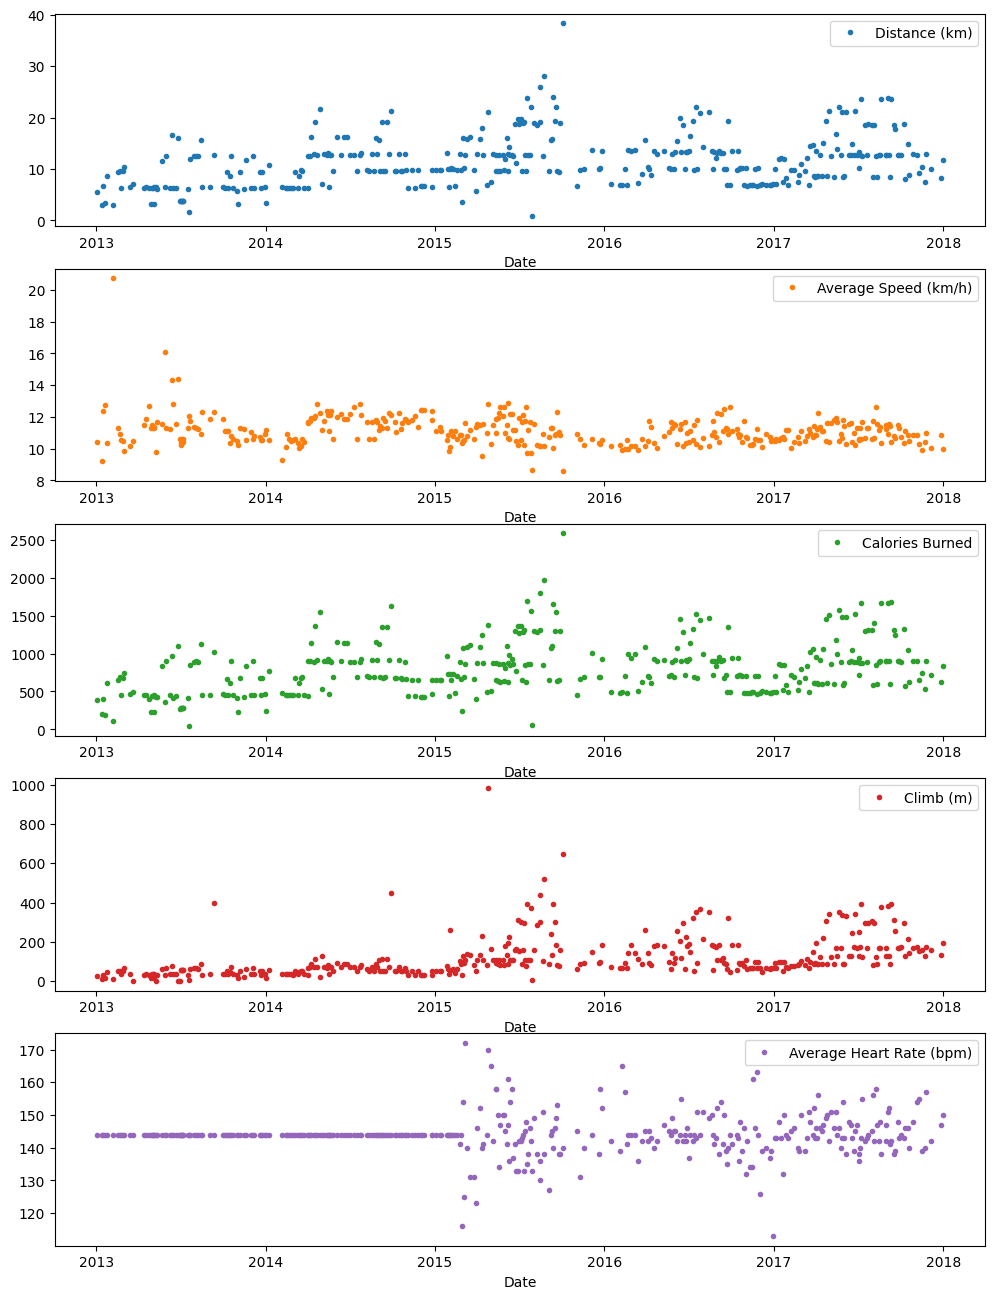

In [6]:
#prepare subset of running data
subset_run_2013_2018 = df_run.loc['20130101':'20180101']

#create plot, and customized in 1 line
subset_run_2013_2018.plot(subplots=True, sharex=False, figsize=(12,16), linestyle='none', marker='o', markersize=3)
#show plot
plt.show()

# Running Statistics

No doubt, running helps people stay mentally and physically healthy and productive at any age. And it is great fun! When runners talk to each other about their hobby, we not only discuss our results, but we also discuss different training strategies.

You'll know you're with a group of runners if you commonly hear questions like:

What is your average distance?
How fast do you run?
Do you measure your heart rate?
How often do you train?
Let's find the answers to these questions in my data. If you look back at plots in Task 4, you can see the answer to, Do you measure your heart rate? Before 2015: no. To look at the averages, let's only use the data from 2015 through 2018.

In pandas, the `resample()` method is similar to the `groupby()` method - with `resample()` you group by a specific time span. We'll use `resample()` to group the time series data by a sampling period and apply several methods to each sampling period. In our case, we'll resample annually and weekly.

In [7]:
#prepare subset of running data 
subset_run_2015_2018 = df_run.loc['20150101':'20190101']

#annual statistics
print("What my average run looks like in the past 4 years: ")
display(subset_run_2015_2018.resample('A').mean())

#weekly statistics
print("Weekly averages over the past 4 years")
display(subset_run_2015_2018.resample('W').mean().mean())

#Average exercises performed each week
num_exercise_weekly = subset_run_2015_2018['Distance (km)'].resample('W').count().mean()
print(f"How many trainings I averaged per week: {num_exercise_weekly}")

What my average run looks like in the past 4 years: 


,Distance (km),Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm)
Date,,,,,
2015-12-31,13.602805,10.998902,932.906138,160.170732,143.353659
2016-12-31,11.411667,10.837778,796.152777,133.194444,143.388889
2017-12-31,12.935176,10.959059,914.164706,169.376471,145.247059
2018-12-31,13.339063,10.777969,952.359375,191.218750,148.125000


Weekly averages over the past 4 years


Distance (km)                12.518176
Average Speed (km/h)         10.835473
Calories Burned             877.861969
Climb (m)                   158.325444
Average Heart Rate (bpm)    144.801775
dtype: float64

How many trainings I averaged per week: 1.5


# Visualizations with Averages

Let's plot the long term averages of my distance run and my heart rate with their raw data to visually compare the averages to each training session. Again, we'll use the data from 2015 through 2018.

In this task, we will use `matplotlib` functionality for plot creation and customization.

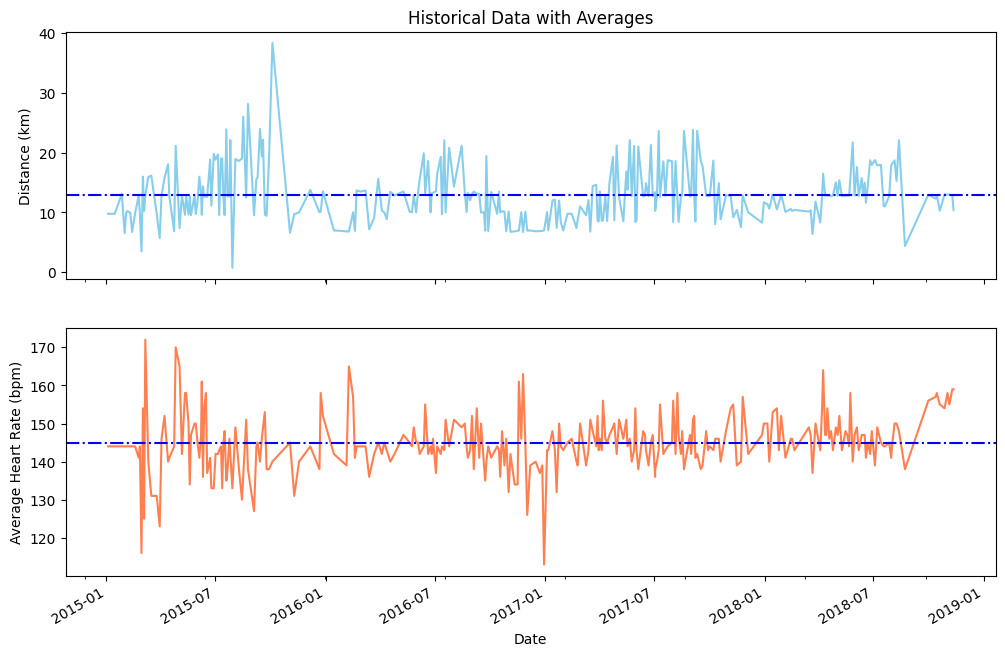

In [8]:
#prepare observations/data for plots
run_distance = subset_run_2015_2018['Distance (km)']
run_hr = subset_run_2015_2018['Average Heart Rate (bpm)']

#create plots
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,8))

#Plot `Distance (km)` for first plot
run_distance.plot(ax=ax1, color='skyblue')
ax1.set(title='Historical Data with Averages', ylabel='Distance (km)')
ax1.axhline(run_distance.mean(), color='blue', linestyle='dashdot')

#Plot `Average Heart Rate (bpm)` for second plot
run_hr.plot(ax=ax2, color='coral')
ax2.set(xlabel='Date', ylabel='Average Heart Rate (bpm)')
ax2.axhline(run_hr.mean(), color='blue', linestyle='dashdot')

# Did I reach my goals?

To motivate myself to run regularly, I set a target goal of running 1000 km per year. Let's visualize my annual running distance (km) from 2013 through 2018 to see if I reached my goal each year. Only stars in the green region indicate success.

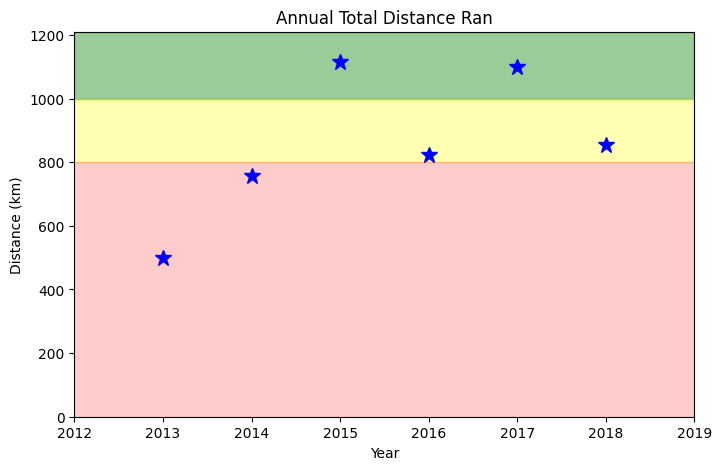

In [9]:
#prepare data
run_annual_dist = df_run.sort_index()['20130101':'20181231']['Distance (km)'].resample('A').sum()

#create blank plot
fig = plt.figure(figsize=(8,5))

#plot and customize
ax = run_annual_dist.plot(marker='*', markersize=12, linewidth=0, color='blue')
ax.set(ylim=[0,1210],
       xlim=['2012','2019'],
       ylabel='Distance (km)',
       xlabel='Year',
       title='Annual Total Distance Ran'
      )
ax.axhspan(1000, 1210, color='green', alpha=0.4)
ax.axhspan(800, 1000, color='yellow', alpha=0.3)
ax.axhspan(0, 800, color='red', alpha=0.2)

#show plot
plt.show()

# Am I progressing?

Let's dive a little deeper into the data to answer a tricky question: am I progressing in terms of my running skills?

To answer this question, we'll decompose my weekly distance run and visually compare it to the raw data. A red trend line will represent the weekly distance run.

We are going to use statsmodels library to decompose the weekly trend.

In [12]:
# Import required library
import statsmodels.api as sm

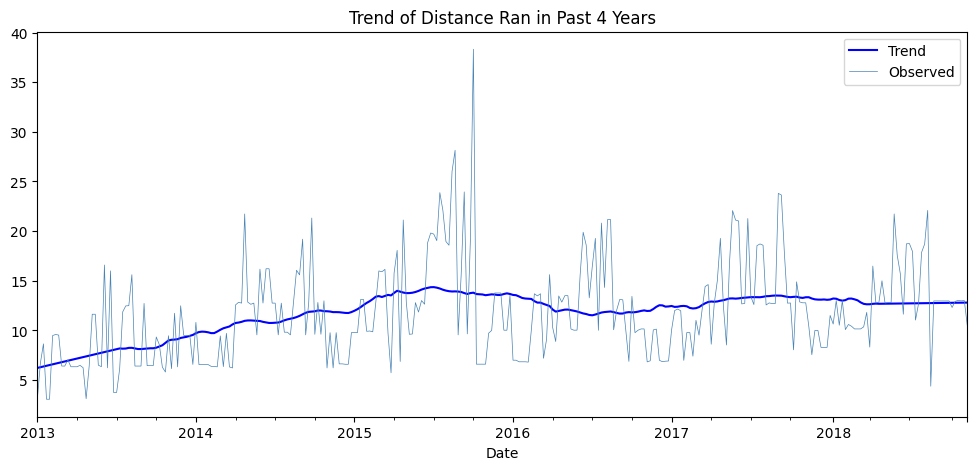

In [13]:
#prepare data
run_dist_weekly = df_run.loc['20130101':'20181231']['Distance (km)'].resample('W').bfill()
decomposed = sm.tsa.seasonal_decompose(run_dist_weekly, extrapolate_trend=1)

#create blank plot
fig = plt.figure(figsize=(12,5))

#plot and customize
ax = decomposed.trend.plot(label='Trend', linewidth=1.5, color='blue')
ax = decomposed.observed.plot(label='Observed', linewidth=0.5, color='steelblue')

ax.legend()
ax.set_title('Trend of Distance Ran in Past 4 Years')

#show plot
plt.show()

# Training intensity

Heart rate is a popular metric used to measure training intensity. Depending on age and fitness level, heart rates are grouped into different zones that people can target depending on training goals. A target heart rate during moderate-intensity activities is about 50-70% of maximum heart rate, while during vigorous physical activity it’s about 70-85% of maximum.

We'll create a distribution plot of my heart rate data by training intensity. It will be a visual presentation for the number of activities from predefined training zones.

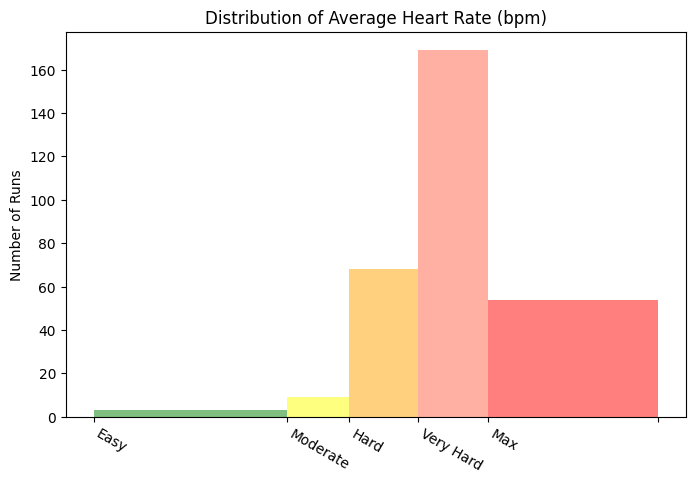

In [19]:
#prepare the data
hr_zones = [100,125,133,142,151, 173]
zone_names = ['Easy','Moderate','Hard','Very Hard','Max', '']
zone_colors = ['green', 'yellow','orange','tomato','red']
df_run_hr_all = df_run.loc['20150101':'20190101']['Average Heart Rate (bpm)']

#create blank histogram
fig, ax = plt.subplots(figsize=(8,5))

#plots and customize
n, bins, patches = ax.hist(df_run_hr_all, bins=hr_zones, alpha=0.5)
for i in range(0, len(patches)):
    patches[i].set_facecolor(zone_colors[i])
    
ax.set(title='Distribution of Average Heart Rate (bpm)',ylabel='Number of Runs')
ax.xaxis.set(ticks=hr_zones)
# ADD LABELS 
ax.set_xticklabels(labels=zone_names, rotation=-30, ha='left')

#show plot
plt.show()

# Detailed summary report

With all this data cleaning, analysis, and visualization, let's create detailed summary tables of my training.

To do this, we'll create two tables. The first table will be a summary of the distance (km) and climb (m) variables for each training activity. The second table will list the summary statistics for the average speed (km/hr), climb (m), and distance (km) variables for each training activity.

In [20]:
# Concatenating three DataFrames
df_run_walk_cycle = df_run.append([df_walk, df_cycle]).sort_index(ascending=False)

dist_climb_cols, speed_col = ['Distance (km)', 'Climb (m)'], ['Average Speed (km/h)']

# Calculating total distance and climb in each type of activities
df_totals = df_run_walk_cycle.groupby('Type')[dist_climb_cols].sum()

print('Totals for different training types:')
display(df_totals)

# Calculating summary statistics for each type of activities 
df_summary = df_run_walk_cycle.groupby('Type')[dist_climb_cols + speed_col].describe()

# Combine totals with summary
for i in dist_climb_cols:
    df_summary[i, 'total'] = df_totals[i]

print('Summary statistics for different training types:')
df_summary.stack()

Totals for different training types:


,Distance (km),Climb (m)
Type,,
Cycling,680.58,6976
Running,5224.50,57278
Walking,33.45,349


Summary statistics for different training types:


Average Speed (km/h)     Climb (m)  Distance (km)
Type                                                            
Cycling 25%               16.980000    139.000000      15.530000
        50%               19.500000    199.000000      20.300000
        75%               21.490000    318.000000      29.400000
        count             29.000000     29.000000      29.000000
        max               24.330000    553.000000      49.180000
        mean              19.125172    240.551724      23.468276
        min               11.380000     58.000000      11.410000
        std                3.257100    128.960289       9.451040
        total                   NaN   6976.000000     680.580000
Running 25%               10.495000     54.000000       7.415000
        50%               10.980000     91.000000      10.810000
        75%               11.520000    171.000000      13.190000
        count            459.000000    459.000000     459.000000
        max               20.720000    982.000000      38.320000
        mean              11.056296    124.788671      11.382353
        min                5.770000      0.000000       0.760000
        std                0.953273    103.382177       4.937853
        total                   NaN  57278.000000    5224.500000
Walking 25%                5.555000      7.000000       1.385000
        50%                5.970000     10.000000       1.485000
        75%                6.512500     15.500000       1.787500
        count             18.000000     18.000000      18.000000
        max                6.910000    112.000000       4.290000
        mean               5.549444     19.388889       1.858333
        min                1.040000      5.000000       1.220000
        std                1.459309     27.110100       0.880055
        total                   NaN    349.000000      33.450000